### Training an RNN

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
input_data = np.array([math.cos(x) for x in np.arange(200)])

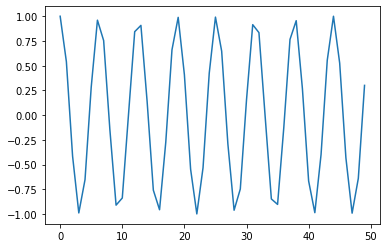

In [3]:
plt.plot(input_data[:50]);

In [4]:
#Let's split the input data into testing and validation sets
X = []
Y = []

size = 50
number_of_records = len(input_data) - size

for i in range(number_of_records - 50):
    X.append(input_data[i:i+size])
    Y.append(input_data[i+size])
    
X = np.array(X)
X = np.expand_dims(X, axis = 2)

Y = np.array(Y)
Y = np.expand_dims(Y, axis = 1)

In [5]:
X.shape, Y.shape

((100, 50, 1), (100, 1))

In [6]:
#Validation set
X_valid = []
Y_valid = []

for i in range(number_of_records - 50, number_of_records):
    X_valid.append(input_data[i:i+size])
    Y_valid.append(input_data[i+size])
    
X_valid = np.array(X_valid)
X_valid = np.expand_dims(X_valid, axis = 2)

Y_valid = np.array(Y_valid)
Y_valid = np.expand_dims(Y_valid, axis = 1)

In [7]:
#Define parameters for the RNN
learning_rate = 0.0001
number_of_epochs = 20
sequence_length = 50
hidden_layer_size = 100
output_layer_size = 1

back_prop_truncate = 5
min_clip_value = -10
max_clip_value = 10

In [8]:
W1 = np.random.uniform(size = (hidden_layer_size, sequence_length))   #Weight matrix for weights between the input and hidden layers
W2 = np.random.uniform(size = (hidden_layer_size, hidden_layer_size))   #...weights between the hidden and output layers
W3 = np.random.uniform(size = (output_layer_size, hidden_layer_size))   #...shared weights in the RNN layer (hidden layer)

In [9]:
#Defining the activation function to be used: sigmoid
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [10]:
"""
Steps for training:
-Check loss on training data: Perform a forward pass, calculate the error
-Check loss on validation data: Perform a forward pass, calculate the error
-Start the training: Perform a forward pass, backpropagate the error, update the weights
""";

In [11]:
for epoch in range(1, number_of_epochs+1):
    #Check loss on train
    loss = 0.0
    
    #Do a forward pass to get prediction
    for i in range(Y.shape[0]):
        x, y = X[i], Y[i]
        prev_act = np.zeros((hidden_layer_size, 1))
        
        for t in range(sequence_length):
            new_input = np.zeros(x.shape)
            new_input[t] = x[t]
            
            mul_w1 = np.dot(W1, new_input)
            mul_w2 = np.dot(W2, prev_act)
            
            add = mul_w2 + mul_w1
            act = sigmoid(add)
            mul_w3 = np.dot(W3, act)
            
            prev_act = act
            
    #Calculate error
        loss_per_record = (y - mul_w3) ** 2 / 2
        loss += loss_per_record
        
    loss = loss / float(y.shape[0])
    
    #Check loss on validation
    val_loss = 0.0
    for i in range(Y_valid.shape[0]):
        x, y = X_valid[i], Y_valid[i]
        prev_act = np.zeros((hidden_layer_size, 1))
        
        for t in range(sequence_length):
            new_input = np.zeros(x.shape)
            new_input[t] = x[t]
            
            mul_w1 = np.dot(W1, new_input)
            mul_w2 = np.dot(W2, prev_act)
            
            add = mul_w2 + mul_w1
            act = sigmoid(add)
            mul_w3 = np.dot(W3, act)
            
            prev_act = act
            
    #Calculate validation error
        loss_per_record = (y - mul_w3) ** 2 / 2
        val_loss += loss_per_record
    
    val_loss = val_loss / float(y.shape[0])
    
    print(f'Epoch {epoch}, Loss: {loss}, Validation loss: {val_loss}')
    
    #Train model
    for i in range(Y.shape[0]):
        x, y = X[i], Y[i]
        layers = []
        prev_act = np.zeros((hidden_layer_size, 1))
        
        dW1 = np.zeros(W1.shape)
        dW3 = np.zeros(W3.shape)
        dW2 = np.zeros(W2.shape)
        
        dW1_t = np.zeros(W1.shape)
        dW3_t = np.zeros(W3.shape)
        dW2_t = np.zeros(W2.shape)
        
        dW1_i = np.zeros(W1.shape)
        dW2_i = np.zeros(W2.shape)
        
        #Forward pass
        for t in range(sequence_length):
            new_input = np.zeros(x.shape)
            new_input[t] = x[t]
            
            mul_w1 = np.dot(W1, new_input)
            mul_w2 = np.dot(W2, prev_act)
            
            add = mul_w2 + mul_w1
            act = sigmoid(add)
            mul_w3 = np.dot(W3, act)
            layers.append({'act': act, 'prev_act': prev_act})
            
            prev_act = act
            
        #Derivative of pred
        dmul_w3 = (mul_w3 - y)
        
        #Backward pass
        for t in range(sequence_length):
            dW3_t = np.dot(dmul_w3, np.transpose(layers[t]['act']))
            dsv = np.dot(np.transpose(W3), dmul_w3)
            
            ds = dsv
            dadd = add * (1 - add) * ds
            
            dmul_w2 = dadd * np.ones_like(mul_w2)
            
            dprev_act = np.dot(np.transpose(W2), dmul_w2)
            
            for i in range(t-1, max(-1, t - back_prop_truncate - 1), -1):
                ds = dsv + dprev_act
                dadd = add * (1 - add) * ds
                
                dmul_w2 = dadd * np.ones_like(mul_w2)
                dmul_w1 = dadd * np.ones_like(mul_w1)
                
                dW2_i = np.dot(W2, layers[t]['prev_act'])
                dprev_act = np.dot(np.transpose(W2), dmul_w2)
                
                new_input = np.zeros(x.shape)
                new_input[t] = x[t]
                
                dW1_i = np.dot(W1, new_input)
                dx = np.dot(np.transpose(W1), dmul_w1)
                
                dW1_t += dW1_i
                dW2_t += dW2_i
                
            dW3 += dW3_t
            dW1 += dW1_t
            dW2 += dW2_t
            
            if dW1.max() > max_clip_value:
                dW1[dW1 > max_clip_value] = max_clip_value
            if dW3.max() > max_clip_value:
                dW3[dW3 > max_clip_value] = max_clip_value
            if dW2.max() > max_clip_value:
                dW2[dW2 > max_clip_value] = max_clip_value
                
            if dW1.min() < min_clip_value:
                dW1[dW1 < min_clip_value] = min_clip_value
            if dW3.min() < min_clip_value:
                dW3[dW3 < min_clip_value] = min_clip_value
            if dW2.min() < min_clip_value:
                dW2[dW2 < min_clip_value] = min_clip_value
                
        #Update
        W1 -= learning_rate * dW1
        W3 -= learning_rate * dW3
        W2 -= learning_rate * dW2

Epoch 1, Loss: [[167561.47083342]], Validation loss: [[83774.88906488]]
Epoch 2, Loss: [[114675.99765104]], Validation loss: [[57333.16931048]]
Epoch 3, Loss: [[71790.52445841]], Validation loss: [[35891.44955096]]
Epoch 4, Loss: [[38904.92734755]], Validation loss: [[19449.6679744]]
Epoch 5, Loss: [[15834.18510091]], Validation loss: [[7915.40393916]]
Epoch 6, Loss: [[714.55879058]], Validation loss: [[357.28587457]]
Epoch 7, Loss: [[31.24931116]], Validation loss: [[15.67439251]]
Epoch 8, Loss: [[31.91549942]], Validation loss: [[16.0235354]]
Epoch 9, Loss: [[31.11309289]], Validation loss: [[15.62728088]]
Epoch 10, Loss: [[31.84749947]], Validation loss: [[16.00063892]]
Epoch 11, Loss: [[31.33493732]], Validation loss: [[15.73615543]]
Epoch 12, Loss: [[31.66083836]], Validation loss: [[15.90438376]]
Epoch 13, Loss: [[31.1340428]], Validation loss: [[15.64097211]]
Epoch 14, Loss: [[32.21800737]], Validation loss: [[16.1882922]]
Epoch 15, Loss: [[31.77043267]], Validation loss: [[15.9

In [12]:
#We can observe that the results converged around the 7the epoch

In [13]:
#Getting the predicted values to be used for plotting

preds = []
for i in range(Y_valid.shape[0]):
    x, y = X_valid[i], Y_valid[i]
    prev_act = np.zeros((hidden_layer_size, 1))
    
    #For each time step...
    for t in range(sequence_length):
        mul_w1 = np.dot(W1, x)
        mul_w2 = np.dot(W2, prev_act)
        
        add = mul_w2 + mul_w1
        act = sigmoid(add)
        
        mul_w3 = np.dot(W3, act)
        
        prev_act = act
        
    preds.append(mul_w3)
    
preds = np.array(preds)

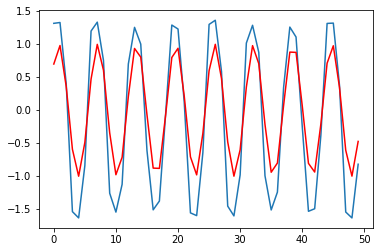

In [15]:
#Plotting the predicted versus the original values
plt.plot(preds[:, 0, 0])
plt.plot(Y_valid[:, 0], 'r');

In [16]:
from sklearn.metrics import mean_squared_error

In [17]:
#Calculate the RMSE (sqrt of variance)
math.sqrt(mean_squared_error(Y_valid[:, 0], preds[:, 0, 0]))

0.5217128953540205

### Creating Intelligent Agents with Reinforcement Learning

In [4]:
%run data/run_rl_environment.py --help

usage: run_rl_environment.py [-h] --input-env {cartpole,mountaincar,pendulum,taxi,lake}

Run an environment

optional arguments:
  -h, --help            show this help message and exit
  --input-env {cartpole,mountaincar,pendulum,taxi,lake}
                        Specify the name of the environment


In [ ]:
%run data/run_rl_environment.py --input-env cartpole